# Euchre Trick Model
Model to estimate the number of tricks a given hand will be able to take  
(or maybe the percent likelihood of each number of tricks taken 0-5)

In [1]:
import pandas as pd

In [2]:
raw_train_df = pd.read_csv('all_hand_results.csv')

In [3]:
raw_train_df.shape

(48176, 14)

In [4]:
raw_train_df.head()

,tricks_won,is_calling_player,teammate_called,has_right,has_left,has_Atrump,has_Ktrump,has_Qtrump,has_Ttrump,has_9trump,num_off_A,num_off_K,num_off_Q,partner_tricks
0,1,0,1,0,0,0,0,0,0,0,1,2,0,2
1,2,0,0,0,1,0,0,1,0,0,0,1,1,0
2,2,1,0,1,0,0,1,0,1,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,1,0,0,2,2
4,2,1,0,1,0,0,1,0,1,0,0,0,1,2


In [5]:
raw_train_df.columns

Index(['tricks_won', 'is_calling_player', 'teammate_called', 'has_right',
       'has_left', 'has_Atrump', 'has_Ktrump', 'has_Qtrump', 'has_Ttrump',
       'has_9trump', 'num_off_A', 'num_off_K', 'num_off_Q', 'partner_tricks'],
      dtype='object')

<AxesSubplot:>

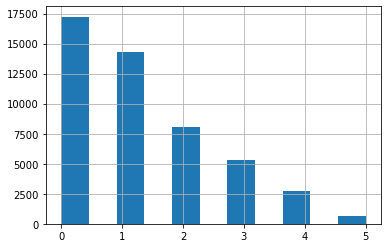

In [6]:
raw_train_df['tricks_won'].hist(bins=11)

### Create train/test/validation splits

In [7]:
model_features = ['has_right', 'has_left',
                  'has_Atrump', 'has_Ktrump', 'has_Qtrump', 'has_Ttrump', 'has_9trump', 
                  'num_off_A', 'num_off_K', 'num_off_Q'
                 ]

In [8]:
from sklearn.model_selection import train_test_split

In [14]:
train_df, test_df, train_targets_df, test_targets_df = train_test_split(raw_train_df[model_features], 
                                                    raw_train_df['tricks_won'], 
                                                    test_size=0.33, random_state=42)

In [15]:
train_df.shape

(32277, 10)

In [16]:
test_df.shape

(15899, 10)

#### Scale Features

In [12]:
from sklearn.preprocessing import StandardScaler

In [13]:
sc = StandardScaler()
train_df = sc.fit_transform(train_df)
test_df = sc.transform (test_df)

## Modeling

#### Linear Regression

In [17]:
from sklearn.linear_model import LinearRegression

In [18]:
reg = LinearRegression().fit(train_df, train_targets_df)

In [19]:
reg.coef_

array([1.67487111, 0.91468558, 0.81636771, 0.84899266, 0.79971991,
       0.76804396, 0.7339185 , 0.45828219, 0.31671623, 0.08987303])

In [35]:
test_preds = reg.predict(test_df)

In [36]:
test_preds[0:5]

array([0.76926004, 1.15166919, 1.42730551, 1.89538952, 0.87313307])

#### Test single hand manually

In [79]:
hand = {feature:[0] for feature in model_features}
single_hand_test_df = pd.DataFrame(hand)
single_hand_test_df

,has_right,has_left,has_Atrump,has_Ktrump,has_Qtrump,has_Ttrump,has_9trump,num_off_A,num_off_K,num_off_Q
0,0,0,0,0,0,0,0,0,0,0


In [80]:
single_hand_test_df['has_right'] = 0
single_hand_test_df['has_left'] = 0
single_hand_test_df['num_off_Q'] = 1
single_hand_test_df['num_off_K'] = 0
single_hand_test_df['num_off_A'] = 2

In [81]:
single_test_pred = reg.predict(single_hand_test_df)
single_test_pred

array([0.46842261])

#### Random Forest

In [42]:
from sklearn.ensemble import RandomForestClassifier

In [43]:
classifier =  RandomForestClassifier(criterion = 'entropy')

In [45]:
# Fit the best algorithm to the data
classifier.fit(train_df, train_targets_df)

RandomForestClassifier(criterion='entropy')

In [69]:
# test_preds = classifier.predict(test_df)
test_preds = classifier.predict_proba(test_df)[0:3]
test_preds

array([[0.61981952, 0.35302517, 0.02715532, 0.        , 0.        ,
        0.        ],
       [0.28070808, 0.50639419, 0.16917861, 0.04371912, 0.        ,
        0.        ],
       [0.01839107, 0.66335842, 0.28269001, 0.0355605 , 0.        ,
        0.        ]])

In [82]:
single_hand_preds = classifier.predict_proba(single_hand_test_df)
single_hand_preds

array([[0.73634202, 0.24439194, 0.01926604, 0.        , 0.        ,
        0.        ]])

In [83]:
trick_preds = single_hand_preds.tolist()[0]
trick_preds

[0.7363420172637817, 0.24439193951637728, 0.019266043219840684, 0.0, 0.0, 0.0]

#### Save out model to disk using joblib

In [85]:
import joblib

In [86]:
pwd

'C:\\Users\\jerem\\Desktop\\nonsense\\euchre'

In [88]:
# TODO: update this to write to C:/Users/jerem/Desktop/nonsense/euchre/models/
# joblib.dump(classifier, 'trick_model_rf_v0.sav')

['trick_model_rf_v0.sav']

#### Plot probability output

In [56]:
import matplotlib.pyplot as plt

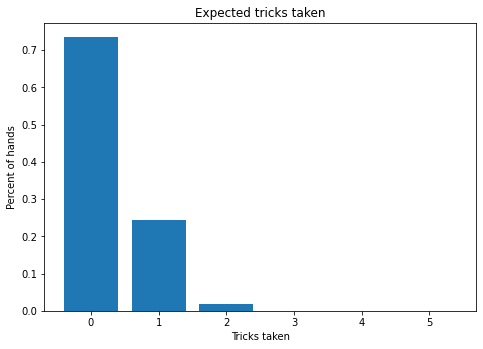

In [91]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
num_tricks_taken = ['0','1','2','3','4','5']
ax.bar(num_tricks_taken, single_hand_preds.tolist()[0])

plt.xlabel("Tricks taken")
plt.ylabel("Percent of hands")
plt.title("Expected tricks taken")

# ax.bar_label(trick_preds, label_type='center')

plt.show()

In [92]:
def plot_expected_tricks_taken(expected_tricks_taken):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.bar(['0','1','2','3','4','5'], expected_tricks_taken)
    plt.xlabel("Tricks taken")
    plt.ylabel("Percent of hands")
    plt.title("Expected tricks taken")
    plt.show()

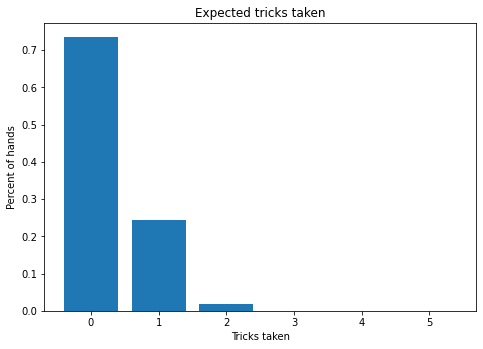

In [93]:
plot_expected_tricks_taken(expected_tricks_taken = trick_preds)

### Evalute model

In [22]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [48]:
mean_absolute_error(y_true=test_targets_df, y_pred=test_preds)

0.4440530850996918

In [49]:
mean_squared_error(y_true=test_targets_df, y_pred=test_preds)

0.5672054846216743

In [50]:
r2_score(y_true=test_targets_df, y_pred=test_preds)

0.6521252351057771

#### Pipeline

In [ ]:
from sklearn.pipeline import Pipeline

In [ ]:
pipe = Pipeline([
        ('scale', StandardScaler()),
        ('reduce_dims', PCA(n_components=4)),
        ('clf', SVC(kernel = 'linear', C = 1))])

## Next Steps

In [ ]:
# Features - add player position at table, team tricks won

# Standardize input features to linear model
# Tree-based models - RF, GBM, etc.
# Look at feature importance

# PyTorch models
    # compare PyTorch version vs. sklearn
# Classification models to predict likelihood for each score outcome

# Streamlit App to return results
    # how to input cards in hand?
    # bar chart of expected returns